In [58]:
import numpy as np
from pc_kriging import PC_Kriging
import matplotlib.pyplot as plt
from scipy.stats import norm
from doepy import build
from scipy import optimize
import pandas as pd
from numpy import genfromtxt
import pickle

# adaptive learning - expected feasiability function --------------------------------------------------------------

def EFF(u,v,z):
    zl=-2*v
    zh=2*v
    return ((u-z)*( 2*norm.cdf((z-u)/v) - norm.cdf((zl-u)/v) - norm.cdf((zh-u)/v)) 
           -(v)*( 2*norm.pdf((z-u)/v) - norm.pdf((zl-u)/v) - norm.pdf((zh-u)/v))  
           +(2*v)*(norm.cdf((zh-u)/v) - norm.cdf((zl-u)/v)))

def U_function(u, v):
    return np.abs(u)/v

def LinearNorm(x,oldmin,oldmax,newmin,newmax):    # scaling linearly X to new domain limits
    return newmin + ((x-oldmin)*(newmax-newmin)/(oldmax-oldmin))


def VoronoiCell(x,xn):   #given x [single value] return the index of the closest xn [array]
    dist=PCK1.distance(x.reshape(1,-1),xn)
    return np.argmin(dist)

In [2]:
# #ground truth function----------------------------------------------------
# https://rprepo.readthedocs.io/en/latest/reliability_problems.html#rp201

def gfun_53(x):
    """Performance function for reliability problem 53.

    Parameters
    ----------
        x : numpy.array of float(s)
            Values of independent variables: columns are the different parameters/random variables (x1, x2,...xn) and rows are different parameter/random variables sets for different calls.

    Returns
    -------
        g_val_sys : numpy.array of float(s)
            Performance function value for the system.
        g_val_comp : numpy.array of float(s)
            Performance function value for each component.
        msg : str
            Accompanying diagnostic message, e.g. warning.
    """
#     import numpy as np
    # expected number of random variables/columns
    nrv_e = 2

    g = float('nan')
    msg = 'Ok'
    x = np.array(x, dtype='f')

    n_dim = len(x.shape)
    if n_dim == 1:
        x = np.array(x)[np.newaxis]
    elif n_dim > 2:
        msg = 'Only available for 1D and 2D arrays.'
        return float('nan'), float('nan'), msg

    nrv_p = x.shape[1]
    if nrv_p != nrv_e:
        msg = f'The number of random variables (x, columns) is expected to be {nrv_e} but {nrv_p} is provided!'
    else:
        g = np.sin(5*x[:, 0]/2) + 2 - (x[:, 0]**2 + 4)*(x[:, 1] - 1)/20

    g_val_sys = g
    g_val_comp = g
    return g_val_sys, g_val_comp, msg

In [5]:
config = {"pol_type": ['hermite', 'hermite']}   #design variables following normal distribution
PCK1 = PC_Kriging(config)
PCK_loo = PC_Kriging(config)    # for LOOCV with same 'config' as specified in the original model

In [ ]:
# objective function to optimize length scale --------------------------------------------------------
def L_Object (l):
    v = 5/2
    N = len(xn)
    R = PCK1.matern(xn , xn, l, v)
    detR = np.linalg.det(R)
    
    modelpar2 = PCK1.train(xn, yn, p, np.array([l,v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
    ### ------------------Theta_ by UQLab User Manual PCK(C. Lataniotis, D. Wicaksono, S. Marelli, B. Sudret)------------------------------
    sig2 = modelpar2[1].reshape(-1)
    # return 0.5*(np.log(detR)+ N*np.log(2*np.pi*sig2)+ N)

    ### ------------------Theta_ by MLE PCK(Schobi,Sudret,Wiart)------------------------------
    FB = PCK1.InfoMat @ modelpar2[0]
    ins = (yn-FB).reshape(-1)
    R_1 = np.linalg.inv(R)
    return ((ins.T) @ R_1 @ ins) * (1/N) * (detR**(1/N))

## Initial training 

In [6]:
### Generating training points
function = gfun_53   #choose the ground truth function
dim = 2       # dimensionality
n = 10       # number of initial sampling

#------------------------------------------------------------
xn = np.zeros((int(n), dim))      #normalized training points
xr = np.zeros((int(n), dim))      #scaled training points
yn = np.zeros((int(n)))           #observations
#------------------------------------------------------------

#initial design of experiments (LHS) --------------------------------
x1mean, x1sigma = 1.5 , 1.0  # normal distribution 
x2mean, x2sigma = 2.5 , 1.0  # normal distribution 

# Check the variables limits for space-filling distribution (NORMAL DISTRIBUTIONS???)
Xdoe = build.space_filling_lhs( {'x1':[-1, 1],      
                                 'x2':[-1, 1],} , 
                                  num_samples = n )
#------------------------------------------------------------
xn[:,0] = Xdoe['x1']
xn[:,1] = Xdoe['x2']
xr[:,0] = PCK1.scalehermite(xn[:,0], x1mean, x1sigma)
xr[:,1] = PCK1.scalehermite(xn[:,1], x2mean, x2sigma)

yn = function(xr)[0]

In [7]:
ntest = 5000  # test points

# TEST POINTS -------------------------------------------------
XR = np.zeros((int(ntest), dim))   #normalized test points
XN = np.zeros((int(ntest), dim))  #scaled test points
YN = np.zeros(int(ntest)) 
#variable 1 ---------------------------------------------------
XN[:,0] = np.random.normal(0,1,ntest)  
XR[:,0] = PCK1.scalehermite(XN[:,0], x1mean, x1sigma)  
#variable 2 ---------------------------------------------------
XN[:,1] = np.random.normal(0,1,ntest)  
XR[:,1] = PCK1.scalehermite(XN[:,1], x2mean, x2sigma)  

YN = function(XR)[0]

# Active training

In [57]:
number_active_points = 10
for points in range(number_active_points):
    # Selecting the best model (length and order) 
    # kernel hyperparameters------------------------------
    v = 5/2
    #n = 11 
    #truncation term-------------------------------------
    p_max = 4  #for each variable → same truncation , degree of expansion
    mse_results = np.zeros(p_max-1)
    opt_length_it = np.zeros(p_max-1)

    dist = PCK1.distance(xr, xr)
    lmax = np.max(dist)
    lmin = np.min(dist[dist!=0])

    for p in range(1, p_max):
        results = dict()
        bounds = [(lmin, lmax)]
        results['shgo'] = optimize.shgo(L_Object, bounds)
        opt_length = results['shgo']['x'][0]

        theta = np.array([opt_length, v])

        modelpar1 = PCK1.train (xn, yn, p, theta) 
        mean0, var0 = PCK1.predict_fast(XN)    # mean, variance

        mse = np.mean ((YN - mean0)**2)
        mse_results[p-1] = mse
        opt_length_it[p-1] = opt_length
        print('Degree', p, 'MSE', "%.2f" % round(mse, 2))

    opt = np.argmin(mse_results) 
    modelpar1 = PCK1.train (xn, yn, opt+1, np.array([opt_length_it[opt], v])) 

    ## Pool of samples
    MCS_samples = 100000

    MCinputs_norm = np.zeros((int(MCS_samples), dim))
    MCinputs = np.zeros((int(MCS_samples), dim))

    MCinputs_norm[:,0] = np.random.normal(0, 1, size=int(MCS_samples))
    MCinputs_norm[:,1] = np.random.normal(0, 1, size=int(MCS_samples))

    MCinputs[:,0] = PCK1.scalehermite(MCinputs_norm[:,0], x1mean, x1sigma)  
    MCinputs[:,1] = PCK1.scalehermite(MCinputs_norm[:,1], x2mean, x2sigma)  

    # ---------------------------------------------------
    ymc = function(MCinputs)[0]  
    fail_samples = np.sum(ymc < 0 )
    Pf_ref = fail_samples/MCS_samples

    meanMC, varMC = PCK1.predict_fast(MCinputs_norm)    # mean, variance
    fail_samples_SUMO = np.sum(np.asarray(meanMC) < 0 )
    fail_prob_SUMO = fail_samples_SUMO / MCS_samples

    print(Pf_ref, fail_prob_SUMO)

    ### Evaluating new points
    U_f = U_function(meanMC.reshape(-1), varMC.reshape(-1))
    xr = np.append(xr, MCinputs[np.argmin(U_f)]).reshape(-1,2)
    xn = np.append(xn, MCinputs_norm[np.argmin(U_f)]).reshape(-1,2)
    yn = function(xr)[0] #Only one point needs to be evaluated here

    print('number of training points: ', len(xn))

/var/folders/q2/7fwghq9d0n55tbk5jb58v79c0000gn/T/ipykernel_38080/2491461283.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  modelpar2 = PCK1.train(xn, yn, p, np.array([l,v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)


Degree 1 MSE 0.68
Degree 2 MSE 0.35
Degree 3 MSE 15.07
0.0312 0.01054
number of training points:  20
Degree 1 MSE 0.69
Degree 2 MSE 0.33
Degree 3 MSE 15.47
0.03125 0.00924
number of training points:  21
Degree 1 MSE 0.71
Degree 2 MSE 0.34
Degree 3 MSE 15.23
0.03154 0.00905
number of training points:  22
Degree 1 MSE 0.71
Degree 2 MSE 0.35
Degree 3 MSE 15.63
0.03121 0.00955
number of training points:  23
Degree 1 MSE 0.72
Degree 2 MSE 0.36
Degree 3 MSE 15.45
0.03131 0.00921
number of training points:  24
Degree 1 MSE 0.74
Degree 2 MSE 0.34
Degree 3 MSE 15.46
0.03126 0.00926
number of training points:  25
Degree 1 MSE 0.25
Degree 2 MSE 0.39
Degree 3 MSE 0.30


KeyboardInterrupt: 

# "Manual" active training

In [46]:
#TRAIN MODEL 
# kernel hyperparameters------------------------------
v = 5/2
#n = 11 
#truncation term-------------------------------------
p_max = 4  #for each variable → same truncation , degree of expansion
mse_results = np.zeros(p_max-1)
opt_length_it = np.zeros(p_max-1)

dist = PCK1.distance(xr, xr)
lmax = np.max(dist)
lmin = np.min(dist[dist!=0])

for p in range(1, p_max):
    results = dict()
    bounds = [(lmin, lmax)]
    results['shgo'] = optimize.shgo(L_Object, bounds)
    opt_length = results['shgo']['x'][0]
    
    theta = np.array([opt_length, v])

    modelpar1 = PCK1.train (xn, yn, p, theta) 
    mean0, var0 = PCK1.predict_fast(XN)    # mean, variance
    
    mse = np.mean ((YN - mean0)**2)
    mse_results[p-1] = mse
    opt_length_it[p-1] = opt_length
    print('Degree', p, 'MSE', "%.2f" % round(mse, 2))
    
opt = np.argmin(mse_results) 
modelpar1 = PCK1.train (xn, yn, opt+1, np.array([opt_length_it[opt], v])) 

/var/folders/q2/7fwghq9d0n55tbk5jb58v79c0000gn/T/ipykernel_38080/2491461283.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  modelpar2 = PCK1.train(xn, yn, p, np.array([l,v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)


Degree 1 MSE 0.70
Degree 2 MSE 0.71
Degree 3 MSE 14.78


MCS and evaluating U function

In [47]:
MCS_samples = 100000

MCinputs_norm = np.zeros((int(MCS_samples), dim))
MCinputs = np.zeros((int(MCS_samples), dim))

MCinputs_norm[:,0] = np.random.normal(0, 1, size=int(MCS_samples))
MCinputs_norm[:,1] = np.random.normal(0, 1, size=int(MCS_samples))

MCinputs[:,0] = PCK1.scalehermite(MCinputs_norm[:,0], x1mean, x1sigma)  
MCinputs[:,1] = PCK1.scalehermite(MCinputs_norm[:,1], x2mean, x2sigma)  

# ---------------------------------------------------
ymc = function(MCinputs)[0]  
fail_samples = np.sum(ymc < 0 )
Pf_ref = fail_samples/MCS_samples

meanMC, varMC = PCK1.predict_fast(MCinputs_norm)    # mean, variance
fail_samples_SUMO = np.sum(np.asarray(meanMC) < 0 )
fail_prob_SUMO = fail_samples_SUMO / MCS_samples

print(Pf_ref, fail_prob_SUMO)

0.03093 0.01324


### Evaluating U function and adding training point

number of training points:  15


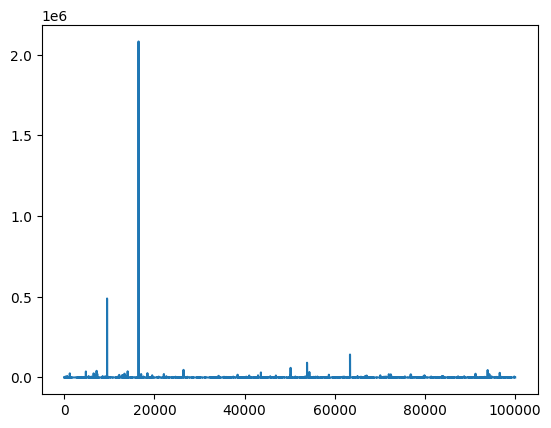

In [45]:
U_f = U_function(meanMC.reshape(-1), varMC.reshape(-1))
#np.argmax(U_f)
#MCinputs_norm[np.argmin(U_f)]
## Add fancy plot
plt.plot(U_f)
#plt.plot(varMC)

xr = np.append(xr, MCinputs[np.argmin(U_f)]).reshape(-1,2)
xn = np.append(xn, MCinputs_norm[np.argmin(U_f)]).reshape(-1,2)

yn = function(xr)[0] #Only one point needs to be evaluated here

print('number of training points: ', len(xn))

## Newly created functions

In [ ]:
def predict_pm (XN):
        ff0 = time.time()
        Rn = PCK1.matern(PCK1.doe, PCK1.doe, PCK1.hyperp[0], PCK1.hyperp[1])
        ff1 = time.time()
        Rn_inv = np.linalg.inv(Rn)
        ff2 = time.time()
        
        size_XN = XN.shape
        mean_predict = np.zeros(size_XN[0])
        var_predict = np.zeros(size_XN[0])
    
        for i in range(size_XN[0]):
            ff22 = time.time()
            fx = PCK1.info_matrix(XN[i].reshape(1,2), PCK1.Poly_ind)
            ff3 = time.time()
            rx = matern_pm(XN[i].reshape(1,2), PCK1.doe, PCK1.hyperp[0], PCK1.hyperp[1])
            ff4 = time.time()
            
            mean1 = fx @ PCK1.coeff
            #ff5 = time.time()
            mean2 = rx @ Rn_inv @ (PCK1.observ - (PCK1.InfoMat @ PCK1.coeff))
            #ff6 = time.time()
            mean_total = mean1 + mean2
            #ff7 = time.time()
                
            ux = ( PCK1.InfoMat.T @ Rn_inv @ rx.T) - fx.T
            #ff8 = time.time()
            term1 = rx @ Rn_inv @ rx.T
            #ff9 = time.time()
            term2 = ux.T @ np.linalg.inv(PCK1.InfoMat.T @ Rn_inv @ PCK1.InfoMat) @ ux
            #ff10 = time.time()
            variance = PCK1.sigmaSQ * ( 1 - term1 + term2)
            #ff11 = time.time()
        
            mean_predict[i] = mean_total
            var_predict[i] = variance[0]
        
        print(ff1 - ff0)
        print(ff2 - ff1)
        print(ff3*10000 - ff22*10000, 'EE')
        print(ff4*10000 - ff3*10000, 'HH')
        #print(ff5*10000 - ff4*10000)
        #print(ff6*10000 - ff5*10000)
        #print(ff7*10000 - ff6*10000)
        #print(ff8*10000 - ff7*10000)
        #print(ff9*10000 - ff8*10000)
        #print(ff10*10000 - ff9*10000)
        #print(ff11*10000 - ff10*10000)
        
        return mean_predict , var_predict

In [ ]:
import math
def matern_pm(xr, xn, l, v):     
    #l, hyperparameter (length scaled)
        #matern parameter, v can be 3/2, 5/2
    
    size_xn = xn.shape
    d = np.linalg.norm(xr - xn, axis=1).reshape(1, size_xn[0])
      
    if v == 3/2:
        R = (1+ np.sqrt(3)*d/l) * np.exp(-(np.sqrt(3)*d/l))
    elif v == 5/2:
        R = ((1+ (np.sqrt(5)*d/l) + (5/3)*(d/l)**2 )* np.exp(-(np.sqrt(5)*d/l)))
        
    return R

def distance_pm(x, xk):                        #multidimensional distance between 2 samples
    d = np.zeros((len(x),len(xk)))
        
    for j in range(0,len(xk)):
        for i in range(0,len(x)):
            d[i,j] = d[i,j] + np.sqrt(np.sum((x[i]-xk[j])**2))
    return d

## Former cells

In [ ]:
#definition of input parameters----------------------------------------------

# seed=0      # fixing seed random number generator
# np.random.seed(seed)         #fixing seed random number generator

function = gfun_53   #choose the ground truth function

dim = 2       # dimensionality
n = 30       # number of initial sampling
ntest = 5000  # test points

#------------------------------------------------------------
xn = np.zeros((int(n), dim))      #normalized training points
xr = np.zeros((int(n), dim))      #scaled training points
yn = np.zeros((int(n)))           #observations
#------------------------------------------------------------

#initial design of experiments (LHS) --------------------------------
x1mean, x1sigma = 1.5 , 1.0  # normal distribution 
x2mean, x2sigma = 2.5 , 1.0  # normal distribution 

# Check the variables limits for space-filling distribution (NORMAL DISTRIBUTIONS???)
Xdoe = build.space_filling_lhs( {'x1':[-1, 1],      
                                 'x2':[-1, 1],} , 
                                  num_samples = n )
#------------------------------------------------------------
xn[:,0] = Xdoe['x1']
xn[:,1] = Xdoe['x2']
xr[:,0] = PCK1.scalehermite(xn[:,0], x1mean, x1sigma)
xr[:,1] = PCK1.scalehermite(xn[:,1], x2mean, x2sigma)

# TEST POINTS -------------------------------------------------
XR = np.zeros((int(ntest), dim))   #normalized test points
XN = np.zeros((int(ntest), dim))  #scaled test points
YN = np.zeros(int(ntest)) 
#variable 1 ---------------------------------------------------
XN[:,0] = np.random.normal(0,1,ntest)  
XR[:,0] = PCK1.scalehermite(XN[:,0], x1mean, x1sigma)  
#variable 2 ---------------------------------------------------
XN[:,1] = np.random.normal(0,1,ntest)  
XR[:,1] = PCK1.scalehermite(XN[:,1], x2mean, x2sigma)  

yn = function(xr)[0]
YN = function(XR)[0]

In [ ]:
YN

In [ ]:
#TRAIN MODEL 
# kernel hyperparameters------------------------------
l = 1.00   #length scale
v = 5/2
theta = np.array([l,v])

#truncation term-------------------------------------
p = 2  #for each variable → same truncation , degree of expansion

modelpar1= PCK1.train (xn,yn,p,theta)    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
modelpar1[0], modelpar1[1]   ## B, sig2,

In [ ]:
import time
# model predictions -----------------------------------------

ntest = 100000  # test points
seed = 0      # fixing seed random number generator
np.random.seed(seed)         #fixing seed random number generator

# test points -------------------------------------------------
XR = np.zeros((int(ntest), dim))   #normalized test points
XN = np.zeros((int(ntest), dim))  #scaled test points
YN = np.zeros(int(ntest)) 
#variable 1 ---------------------------------------------------
XN[:,0] = np.random.normal(0,1,ntest)  
XR[:,0] = PCK1.scalehermite(XN[:,0], x1mean, x1sigma)  
#variable 2 ---------------------------------------------------
XN[:,1] = np.random.normal(0,1,ntest)  
XR[:,1] = PCK1.scalehermite(XN[:,1], x2mean, x2sigma)  

G_VAL_SYS = function(XR)
YN = G_VAL_SYS[0]

#a0 = time.time()
#mean1, var1 = PCK1.predict(XN)
a1 = time.time()

mean2, var2 = PCK1.predict_fast(XN)
a2 = time.time()

#mse = np.mean ((YN - mean1)**2)
#print(mse)
print(mean2, var2)
print(a2-a1)

In [ ]:
# Polynomial with the smallest MSE for the given DOE --------------------------------------
v= 5/2       #matern coefficient
PCK0 = PC_Kriging(config)

#selecting length scale ------------
dist = PCK1.distance(xr, xr)
lmax = np.max(dist)
lmin = np.min(dist[dist!=0])
l= results['shgo']['x']
    
if (l < lmin and l > lmax ):
    l = lmin
    
maxpoly = 10

for j in range (1,maxpoly): 
    # MODEL TRAINING
    modelpar0 = PCK0.train (xn,yn,j,theta)    # returns B, sig2

    # MODEL PREDICTIONS
    mean0,var0 = PCK0.predict(XN)    # mean, variance
    
    # generalization error  ---------------------------------------------
    mse = np.mean ((YN - mean0)**2)
    
    print('Degree', j, 'MSE', "%.2f" % round(mse, 2))

In [ ]:
# Polynomial with the smallest MSE for the given DOE --------------------------------------
v= 5/2       #matern coefficient
PCK0 = PC_Kriging(config)

#selecting length scale ------------
dist = PCK1.distance(xr, xr)
lmax = np.max(dist)
lmin = np.min(dist[dist!=0])

In [3]:
# objective function to optimize length scale --------------------------------------------------------
def L_Object (l):
    v = 5/2
    N = len(xn)
    R = PCK1.matern(xn , xn, l, v)
    detR = np.linalg.det(R)
    
    modelpar2 = PCK1.train(xn, yn, p, np.array([l,v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
    ### ------------------Theta_ by UQLab User Manual PCK(C. Lataniotis, D. Wicaksono, S. Marelli, B. Sudret)------------------------------
    sig2 = modelpar2[1].reshape(-1)
    # return 0.5*(np.log(detR)+ N*np.log(2*np.pi*sig2)+ N)

    ### ------------------Theta_ by MLE PCK(Schobi,Sudret,Wiart)------------------------------
    FB = PCK1.InfoMat @ modelpar2[0]
    ins = (yn-FB).reshape(-1)
    R_1 = np.linalg.inv(R)
    return ((ins.T) @ R_1 @ ins) * (1/N) * (detR**(1/N))

In [ ]:
# objective function to optimize length scale --------------------------------------------------------
def L_Object (l):
    v=5/2
    N=len(xn)
    R = PCK1.matern(xn , xn, l, v)
    detR = np.linalg.det(R)
    
    modelpar2 = PCK1.train(xn, yn, p, np.array([l,v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
    ### ------------------Theta_ by UQLab User Manual PCK(C. Lataniotis, D. Wicaksono, S. Marelli, B. Sudret)------------------------------
    sig2 = modelpar2[1].reshape(-1)
    # return 0.5*(np.log(detR)+ N*np.log(2*np.pi*sig2)+ N)

    ### ------------------Theta_ by MLE PCK(Schobi,Sudret,Wiart)------------------------------
    FB = PCK1.InfoMat @ modelpar2[0]
    ins = (yn-FB).reshape(-1)
    R_1 = np.linalg.inv(R)
    return ((ins.T) @ R_1 @ ins) * (1/N) * (detR**(1/N))
    
results = dict()
bounds = [(lmin, lmax)]

results['shgo'] = optimize.shgo(L_Object, bounds)   #bounds must be a list [lmin, lmax]
results['DA'] = optimize.dual_annealing(L_Object, bounds)
results['DE'] = optimize.differential_evolution(L_Object, bounds)

bounds, results['shgo']['x'], results['DA']['x'],results['DE']['x']

In [ ]:
# Polynomial with the smallest MSE for the given DOE --------------------------------------
v= 5/2       #matern coefficient
PCK0 = PC_Kriging(config)

#selecting length scale ------------
dist = PCK1.distance(xr, xr)
lmax = np.max(dist)
lmin = np.min(dist[dist!=0])
l= results['shgo']['x']
    
if (l < lmin and l > lmax ):
    l = lmin
    
maxpoly = 10

for j in range (1,maxpoly): 
    # MODEL TRAINING
    modelpar0 = PCK0.train (xn,yn,j,theta)    # returns B, sig2

    # MODEL PREDICTIONS
    mean0,var0 = PCK0.predict(XN)    # mean, variance
    
    # generalization error  ---------------------------------------------
    mse = np.mean ((YN - mean0)**2)
    
    print('Degree', j, 'MSE', "%.2f" % round(mse, 2))

In [ ]:
#################################################################
# FIXED VALUES --------------------------------------
# v= 5/2       #matern coefficient
p = 2        #truncation term
z = 0        #target value 

# MCS ------------------------------------------------

MCS_samples = 100

MCinputs_norm = np.zeros((int(MCS_samples), dim))
MCinputs = np.zeros((int(MCS_samples), dim))

MCinputs_norm[:,0] = np.random.normal(0, 1, size=int(MCS_samples))
MCinputs_norm[:,1] = np.random.normal(0, 1, size=int(MCS_samples))

MCinputs[:,0] = PCK1.scalehermite(MCinputs_norm[:,0], x1mean, x1sigma)  
MCinputs[:,1] = PCK1.scalehermite(MCinputs_norm[:,1], x2mean, x2sigma)  

# ---------------------------------------------------
ymc = function(MCinputs)[0]  
fail_samples = np.sum(ymc < 0 )
Pf_ref = fail_samples/MCS_samples

#################################################################
# LOOP ----------------------------------------------------------
budget = 10

Pf_SUMO = []
eff1 = np.zeros(ntest)

for j in range (1,budget): 

    # UPDATE n, xn, xr, yn
    
    n=len(xn)
    LOOCV = np.zeros(ntest)
    mean_loo = np.zeros(n)
    var_loo = np.zeros(n)

    #model evaluations -----------------
    yn = function(xr)[0]

    #selecting length scale ------------
    results = dict()
    
    dist = PCK1.distance(xn, xn)
    lmax = np.max(dist)
    lmin = np.min(dist[dist!=0])
    bounds = [(lmin, lmax)]
    
    results['shgo'] = optimize.shgo(L_Object, bounds)
    l= results['shgo']['x']
    
    if (l < lmin and l > lmax ):
        l = lmin
    
    print(l, lmin, lmax)
#     l = np.min(dist[dist!=0])     #assigning the minimum distance between two points

    theta = np.array([l,v])

    # MODEL TRAINING
    modelpar1 = PCK1.train (xn,yn,p,theta)    # returns B, sig2

    # MODEL PREDICTIONS
    mean1,var1 = PCK1.predict(XN)    # mean, variance

    # LOO CV errors ###################################################
    #Generating PCK models for each reduced design of experiments 

#     for i in range (0,n):             
#         yn_loo=  np.delete(yn,[i])                              #y_n-i      leaving element i out the observations 
#         xr_loo= np.delete(xr,[i*2,i*2+1]).reshape(-1,dim)      #x1r_n-i   leaving element i out the inputs (xr)
#         xn_loo= np.delete(xn,[i*2,i*2+1]).reshape(-1,dim)      #x_n-i     leaving element i out the nomalized inputs (xn)

#         #training LOO
#         modelpar_loo = PCK_loo.train (xn_loo,yn_loo,p,theta)   # same (p) as specified in the original model

#         #predicting LOO
#         mean_loo[i], var_loo[i] = PCK_loo.predict(xn[i].reshape(1,-1))



#     e_loo = (yn - mean_loo)**2              #LOO CV squared errors
#     sumat = np.divide(e_loo,var_loo)        #vector (e_loo / s_loo) for each observed point


#     for k in range (0,ntest):               #variance enhancement based LOO CV erros around voronoi cells
#         voro = VoronoiCell(XR[k],xr)

#         LOOCV[k]= var_plot[k]*(1+sumat[voro])   
    ####################################################
    #Pf estimation ------------------------------------------
    #surrogate pred -----------------------------------------
    mean_MCS = []
    
    # var_MCS = []

    for m in range (0, int(MCS_samples)):
        mean_,var_ = PCK1.predict(MCinputs_norm[m].reshape(1,-1))
        mean_MCS.append(mean_.tolist())
    #     var_MCS.append(var_.tolist())

    fail_samples_SUMO = np.sum(np.asarray(mean_MCS) < 0 )
    fail_prob_SUMO = fail_samples_SUMO / MCS_samples
    Pf_SUMO.append(fail_prob_SUMO.tolist())
    #################################################### 
    
    #-------------------------------------- EFF
#     eff1 = EFF(np.squeeze(mean1),LOOCV,z)    #with LOO cv

    eff1 = EFF(np.squeeze(mean1),var1,z)

    maxEff = np.argmax(eff1)
    Xr_new = XR[maxEff]
    Xn_new = XN[maxEff]
    
    #-------------------------------------- U_function
# #     U_f = U_function(mean1.reshape(-1), LOOCV.reshape(-1))    #with LOO cv
#     U_f = U_function(mean1.reshape(-1), var1.reshape(-1))
    
#     minU = np.argmin(U_f)
#     Xr_new = XR[minU]   

    # adding observation and updating -----------------------------------
    xr = np.append(xr,Xr_new).reshape(-1,2)
    xn = np.append(xn,Xn_new).reshape(-1,2)
    
    # generalization error  ---------------------------------------------
    mse = np.mean ((YN - mean1)**2)
    ####################################################
    #Pf estimation ------------------------------------------
    #surrogate pred -----------------------------------------
    mean_MCS = []

    for m in range (0, int(MCS_samples)):
        mean_,var_ = PCK1.predict(MCinputs_norm[m].reshape(1,-1))
        mean_MCS.append(mean_.tolist())

    fail_samples_SUMO = np.sum(np.asarray(mean_MCS) < 0 )
    fail_prob_SUMO = fail_samples_SUMO / MCS_samples
    Pf_SUMO.append(fail_prob_SUMO.tolist())
    
    pf_error = np.abs( (Pf_ref - fail_prob_SUMO)) / Pf_ref 
    ####################################################
    print(j, 'Pf ', "%.4f" % round(fail_prob_SUMO, 4) , 'pf_error', "%.2f" % round(pf_error, 2) )
    
yn = function(xr)[0]